# Import required libraries


The library [gym](https://gym.openai.com/) is an open-source library, which gives you access to a standardized set of environments to simulate different RL algorithms.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import matplotlib
import pickle
import string

from gym import Env, spaces
from gym.utils import seeding

import datetime
import os

In [56]:
now = datetime.datetime.now()

############################################################################################
# we study 3 possible internal representations, the index of the representation is defined at the beginning of the notebook, inthe seceon cell
internal_representation = 2 # 0=time index, 1=position and time index, 2=position index and rear touching (0,1) 

if internal_representation == 0:
    results_folder = 'Results-Front-0.5-TimeIndex-' + str(now)[:16]
    file_to_save_name = 'Results_TimeIndex.pickle'
elif internal_representation == 1:
    results_folder = 'Results-Front-0.5-TimePositionIndex-' + str(now)[:16]
    file_to_save_name = 'Results_TimePositionIndex.pickle'
else: 
    results_folder = 'Results-Front-0.5-PositionIndexRearWall-' + str(now)[:16]
    file_to_save_name = 'Results_PositionIndexRearWall.pickle'

############################################################################################

os.mkdir(results_folder)

# Agent-Environment interaction

## Define discrete dynamics of the environment and reward schedule

In [57]:
# this is to sample from a discrete distribution, for the initial state distribution
def categorical_sample(prob_n, np_random): 
    """
    Sample from categorical distribution
    Each row specifies class probabilities
    """
    prob_n = np.asarray(prob_n)
    csprob_n = np.cumsum(prob_n)
    return (csprob_n > np_random.rand()).argmax()

# the class DiscreteEnv slightly modified
class DiscreteEnv_v2(Env):

    """
    Has the following members
    - nS: number of states
    - nA: number of actions
    - P: transitions (*)
    - isd: initial state distribution (**)
    (*) dictionary dict of dicts of lists, where
      P[s][a] == [(probability, nextstate, reward, done), ...]
    (**) list or array of length nS
    """
    def __init__(self, nS, nA, P, isd):
        self.P = P
        self.isd = isd
        self.lastaction=None # for rendering
        self.nS = nS
        self.nA = nA

        self.action_space = spaces.Discrete(self.nA)
        self.observation_space = spaces.Discrete(self.nS)

        self.seed()
        self.reset()
    
    def seed(self, seed=None):
        seed = 0
        self.np_random, seed = seeding.np_random(seed)
        seed = 0

        return [seed]
        

    def reset(self):
        self.s = categorical_sample(self.isd, self.np_random)
        self.lastaction = None
        if self.s == 0:            
            self.enterone = False
        else:
            self.enterone = True
            
        return self.s, self.enterone
        
    def step(self, a, time,t_min,t_max,t_exit):      
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s  = transitions[i]
        self.s = s # the new state becomes the actual one 
        self.enterone = self.update_enterone()        
        
        #print(self)
        #print(time)
        
        r, d = self.generate_reward(time,t_min,t_max,t_exit)
        #self.lastaction = a
        return (s, r, d, {"prob" : p})
        #return (s, {"prob" : p})
           
        
           
    def generate_reward(self, time,t_min,t_max,t_exit):    
        

        
        
        if (time==t_exit and self.enterone==False): # being away of s=0 (reward zone) maximum at t_exit+1 
        
            reward = -1
            end_trial = True
        
        if (self.s == 0 or self.s == int(self.nS/2)): 

            if (time<t_min):
                
                reward = -1
                end_trial = True
            
            if (time>=t_min and time<t_max):
                r=[3 - 3/(time_max-time_min)*i for i in range(int(time_max-time_min))]
                    
                reward = r[int(time-time_min)]
                end_trial = True
    
        else:
            
            if time < time_max-1:
                reward = -.1 #-.1
                end_trial = False
          
            
            if time==t_max-1: # this can only be time == t_max if in the trial loop time<=time_max            
                reward = -.5
                end_trial = True
        

    
        return reward, end_trial
    
    
    def update_enterone(self):
        #time += 1
        
        if (self.enterone == False):             
            if self.s == 0:                
                self.enterone = False        
            else:            
                self.enterone = True        
        return self.enterone

In [58]:
#r=[3 - 3/(time_max-time_min)*i for i in range(int(time_max-time_min))]                   
#r


In [59]:
class SimpleTreadmillEnv(DiscreteEnv_v2):

    def __init__(self):

        nS = 10 # must be an even number
        nA = 3
        
        #isd = np.zeros(nS)
        #isd[0] = 1 # trials always begin with the rat at the front of the treadmill
        
        alpha = 0.5
        isd = [alpha*(1-alpha)**i for i in range(int(nS/2))]
        isd = isd/np.sum(isd)                                         
        
        #alpha = [.9,.2]
        #isd = [alpha[0]*(1-alpha[0])**i + alpha[1]*(1-alpha[1])**(int(nS/2)-1-i)  for i in range(int(nS/2))]       
        #isd = isd/np.sum(isd)
        
        
        
        P = {s : {a : [] for a in range(nA)} for s in range(nS)}
        for s in range(nS):
            for a in range(nA):
                if a == 0:
                    if s == int(nS/2)-1 or s == nS-1:
                        newstate = nS-1 # cannot enter the rear wall

                    else:   
                        newstate = s+1            
            
                elif a == 1:
                
                    if s == int(nS/2)-1:                    
                        newstate = nS-1
                                                           
                    else:
                        newstate = s
            
                else:
                    if s == 0 or s == int(nS/2):
                        newstate = s
                    elif s == int(nS/2)-1:
                        newstate = nS-2                       
                    else:
                        newstate = s-1
                    
                P[s][a].append((1.0,newstate))
        DiscreteEnv_v2.__init__(self, nS, nA, P, isd)  


## Define the internal state


In [60]:
def get_internal_state(internal_representation,time,state,n_positions,pos_ind):

    if internal_representation == 0:
        internal_state = time # the internal state is the time index
    elif internal_representation == 1:
        internal_state = (time)*n_positions + pos_ind[state] # the internal state is the position and time index
    else: 
        internal_state = state # the internal state is the position index and touching the rear (0,1)

    return internal_state

## Define epsilon greedy and softmax policy

In [61]:
def epsilon_greedy_policy(Q,i_current,epsilon=.1):
    
    if np.random.random()<=epsilon  or np.sum(Q[i_current,:]==0):
        a_current = np.random.randint(0,Q.shape[1])      
    else:
        a_current = np.argmax(Q[i_current,:])
        
    return a_current 

###############################################################
def softmax(x,beta): # this is just the softmax distribution
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(beta*(x - np.max(x)))
    return e_x / e_x.sum()


def softmax_policy(Q,s_current,p_current,nS,beta = 3): # nS is the number of positions
    
    Q_current = Q[s_current,:]
    action_prob = softmax(Q_current,beta) # probability of each action, Q_current = Q[i_current,:]
    
    # this is a constraint related to the environment
    ###################################################
    if (p_current == 0):
        action_prob[2] = 0
        action_prob = action_prob/np.sum(action_prob)
    elif (p_current == int(nS/2)-1):
        action_prob[0] = 0
        action_prob = action_prob/np.sum(action_prob)        
    else:
        action_prob = action_prob
    ###################################################
    
    prob_n = np.asarray(action_prob)
    csprob_n = np.cumsum(prob_n)
    a_current = (csprob_n > np.random.rand()).argmax()
        
    return a_current


## Define Q learning-update

In [62]:
def Q_learning_update(i_current,a_current,rew,i_next,Q,end_trial,alpha=.1,gamma=.98):
    
    if end_trial == 0:
        delta = rew + gamma*np.max(Q[i_next,:]) - Q[i_current,a_current] # td rule for Q-learning
    else:
        delta = rew + gamma*0 - Q[i_current,a_current] # td rule for Q-learning, value of exit state is 0

    Q[i_current,a_current] += alpha*delta
    
    return Q, delta

# Functions for final plots

In [63]:
def add_panel_caption(axes: tuple, offsetX: tuple, offsetY: tuple, **kwargs):
    """
    This function adds letter captions (a,b,c,d) to Axes in axes
    at top left, with the specified offset, in RELATIVE figure coordinates
    """
    assert len(axes)==len(offsetX)==len(offsetY), 'Bad input!'
    
    fig=axes[0].get_figure()
    fbox=fig.bbox
    for ax,dx,dy,s in zip(axes,offsetX,offsetY,string.ascii_lowercase):
        axbox=ax.get_window_extent()
    
        ax.text(x=(axbox.x0/fbox.xmax)-abs(dx), y=(axbox.y1/fbox.ymax)+abs(dy),
                s=s,fontweight='extra bold', fontsize=10, ha='left', va='center',
               transform=fig.transFigure,**kwargs)


In [64]:
def plot_learning_curve(ax,variable_to_plot,goalTime,seed_vector,n_sessions,TaskParamToPlot,color='k'):

    #goalTime=7
    
    x=np.arange(n_sessions)+1
    data=variable_to_plot
    y=np.nanpercentile(data,50,axis=0)
    yerr=np.nanpercentile(data,(25,75),axis=0)
    ax.errorbar(x,y,yerr=abs(yerr-y), ecolor=color, fmt='-o',color=color,
                elinewidth=1, markersize=4, markerfacecolor='w',zorder=3)
    
    
    if TaskParamToPlot=="ET":
        ax.hlines(y=goalTime, xmin=x[0], xmax=x[-1], linestyle='--', lw=1, color='m', zorder=1)
        ax.text(x=x[20], y=10, s=f'$n={len(seed_vector)}$ agents', fontsize='xx-small', zorder=5)
        ax.set_ylim([0,12])
        ax.set_yticks([0,3.5,7,10.5])
        ax.set_yticklabels([0,'',7,''])


    
    ax.set_xlim([x[0]-1,x[-1]+1])
    xtick=[1]
    for i in range(1,n_sessions+1):
        if i%5==0:
            xtick.append(i)
    ax.set_xticks(xtick)
    ax.spines['bottom'].set_bounds(x[0],x[-1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    
    #ax.set_xlabel('Session#')
    #ax.set_ylabel(TaskParamToPlot)
    
    return ax

In [65]:
def plot_agent_ET(ax, med, highError, lowError,goalTime,n_sessions,color='k'):
    
    
    x = [i+1 for i in range(n_sessions)]
    
    ax.errorbar(x,med,yerr=np.vstack([med-lowError,highError-med]),
                ecolor=color, fmt='-o',color=color,elinewidth=1, markersize=4,
                markerfacecolor='w',zorder=3)


    ax.hlines(y=goalTime, xmin=x[0], xmax=x[-1], linestyle='--', lw=1, color='m', zorder=1)
    ax.set_ylim([0,12])
    ax.set_yticks([0,3.5,7,10.5])
    ax.set_yticklabels([0,'',7,''])


    
    ax.set_xlim([x[0]-1,x[-1]+1])
    xtick=[1]
    for i in range(1,n_sessions+1):
        if i%5==0:
            xtick.append(i)
    ax.set_xticks(xtick)
    ax.spines['bottom'].set_bounds(x[0],x[-1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    
    ax.set_xlabel('Session#')
    ax.text(x=x[-1], y=10, s='seed #' + str(30), zorder=5,ha='right',fontsize='xx-small')
    
    

    

In [66]:
def plot_agent_SD(ax, var_to_plot, seed_number,n_sessions,color='olive'):

    data=var_to_plot
    x=np.arange(len(data))+1
    ax.plot(x,data, color=color, marker='o',linestyle='-',linewidth=1, markersize=4, markerfacecolor='w',zorder=3)

In [67]:
def plot_trajectory_distributions(fig, gs,p_TR_correct,p_TR_error,p_TR_omission,sequence_all_states,correct_all,cmapCorrect,cmapError,cmapOmission,selected_sessions,alpha=0.5):
    
    n_states = int(2*p_TR_correct.shape[0])
    pos_ind = np.concatenate(([i for i in range(int(n_states/2))],[i for i in range(int(n_states/2))]),axis=0)

    axes=[]
    for i_p, i_s in enumerate(selected_sessions):
    
        ax=fig.add_subplot(gs[i_p])
        axes.append(ax)
    
        ax.pcolor(p_TR_correct[:,:,i_s], edgecolors='none', linewidths=1, cmap=cmapCorrect, vmin=0.0, vmax=1.0,alpha=alpha)

        ax.pcolor(p_TR_error[:,:,i_s], edgecolors='none', linewidths=1, cmap=cmapError, vmin=0.0, vmax=1.0,alpha=alpha)
        
        ax.pcolor(p_TR_omission[:,:,i_s], edgecolors='none', linewidths=1, cmap=cmapOmission, vmin=0.0, vmax=1.0,alpha=alpha)

                
        for ind_t in range(sessions[i_s],sessions[i_s+1]):
            l = len(pos_ind[sequence_all_states[ind_t]])
            
            if correct_all[ind_t] == True:
                color_plot = 'Olive'
            elif correct_all[ind_t] == False : 
                color_plot = 'Tomato'
            else :
                color_plot = 'gray'
                        
            ax.plot([i+.5 for i in range(l)],pos_ind[sequence_all_states[ind_t]]+.5, '-',
                    color = color_plot, linewidth=.8,alpha=.02)
        
        ax.set_xticks([i+0.5 for i in range(0,20,5)])
        ax.set_xticklabels([str(i) for i in range(0,20,5)])
    
        ax.set_yticks([i+0.5 for i in range(5)])
        if i_p == 0:
            ax.set_yticklabels([str(i) for i in range(5)])
        else:
            ax.set_yticklabels([])

    
    
        ax.set_xlim(0,16)

    
        ax.set_title('Session #' + str(i_s+1),fontsize=10)
        if i_p == 0:            
            ax.set_ylabel('Position index')                    
        ax.set_xlabel('Time index')
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    return axes
##########################################################

def add_legend_trajectory(ax):
    err_marker = matplotlib.lines.Line2D([0],[0],color='Tomato',label='Error')

    corr_marker = matplotlib.lines.Line2D([0], [0],color='Lime',label='Correct')
    
    omis_marker = matplotlib.lines.Line2D([0], [0], color='Gray',label='Omission')


    leg=ax.legend(handles=[err_marker,corr_marker,omis_marker],loc=(.4,.55),labelspacing=0.2, ncol=1, fontsize=6, framealpha=0)
    
    return leg

In [79]:
def plot_final_trajectory_many_agents(fig, gs,p_TR_correct,p_TR_error,p_TR_omission,sequence_all_states,correct_all,cmapCorrect,cmapError,cmapOmission,selected_agents,alpha=0.5):
    
    tps = 100
    n_states = int(2*p_TR_correct.shape[0])
    pos_ind = np.concatenate(([i for i in range(int(n_states/2))],[i for i in range(int(n_states/2))]),axis=0)

    axes=[]
    for i_p, i_a in enumerate(selected_agents):
    
        ax=fig.add_subplot(gs[i_p])
        axes.append(ax)
    
        ax.pcolor(p_TR_correct[:,:,i_a], edgecolors='none', linewidths=1, cmap=cmapCorrect, vmin=0.0, vmax=1.0,alpha=alpha)

        ax.pcolor(p_TR_error[:,:,i_a], edgecolors='none', linewidths=1, cmap=cmapError, vmin=0.0, vmax=1.0,alpha=alpha)
        
        ax.pcolor(p_TR_omission[:,:,i_a], edgecolors='none', linewidths=1, cmap=cmapOmission, vmin=0.0, vmax=1.0,alpha=alpha)

                
        for ind_t in range(i_a*tps,(i_a+1)*tps):
            l = len(pos_ind[sequence_all_states[ind_t]])
            
            if correct_all[ind_t] == True:
                color_plot = 'Olive'
            elif correct_all[ind_t] == False : 
                color_plot = 'Tomato'
            else :
                color_plot = 'gray'
                        
            ax.plot([i+.5 for i in range(l)],pos_ind[sequence_all_states[ind_t]]+.5, '-',
                    color = color_plot, linewidth=.8,alpha=.02)
        
        ax.set_xticks([i+0.5 for i in range(0,20,5)])
        ax.set_xticklabels([str(i) for i in range(0,20,5)])
    
        ax.set_yticks([i+0.5 for i in range(5)])
        if i_p == 0:
            ax.set_yticklabels([str(i) for i in range(5)])
        else:
            ax.set_yticklabels([])

    
    
        ax.set_xlim(0,16)

    
        if i_p == 0:            
            ax.set_ylabel('Position index')                    
            ax.set_xlabel('Time index')
            ax.set_title('Session #30',fontsize=10)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    return axes
##########################################################

In [ ]:
def plot_trajectory_distributions_separated(fig, gs,p_TR_correct,p_TR_error,cmapCorrect,cmapError,selected_sessions,alpha=1):
    
    axes=[]
    for i_p, i_s in enumerate(selected_sessions):
    #############################################
    # Correct trials
        ax=fig.add_subplot(gs[i_p])
        axes.append(ax)   
        ax.pcolor(p_TR_correct[:,:,i_s], edgecolors='none', linewidths=1, cmap=cmapLime, vmin=0.0, vmax=1.0,alpha=alpha)

        ax.set_xticks([i+0.5 for i in range(0,20,5)])
        ax.set_xticklabels([str(i) for i in range(0,20,5)])
    
        ax.set_yticks([i+0.5 for i in range(5)])
        if i_p == 0:
            ax.set_yticklabels([str(i) for i in range(5)])
        else:
            ax.set_yticklabels([])

    
    
        ax.set_xlim(0,16)

    
        ax.set_title('Session #' + str(i_s+1),fontsize=10)
        #ax.set_xlabel('Time index')
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    #############################################
    # Error trials        
        ax=fig.add_subplot(gs[i_p+len(selected_sessions)])
        axes.append(ax) 
        ax.pcolor(p_TR_error[:,:,i_s], edgecolors='none', linewidths=1, cmap=cmapTomato, vmin=0.0, vmax=1.0,alpha=alpha)
        
        ax.set_xticks([i+0.5 for i in range(0,20,5)])
        ax.set_xticklabels([str(i) for i in range(0,20,5)])
    
        ax.set_yticks([i+0.5 for i in range(5)])
        if i_p == 0:
            ax.set_yticklabels([str(i) for i in range(5)])
        else:
            ax.set_yticklabels([])

    
    
        ax.set_xlim(0,16)
                 
        ax.set_xlabel('Time index')
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    
    
    return axes
    

In [ ]:
def plot_entrance_times(fig, gs,sessions,selected_sessions,correct_all,entrance_times,goalTime):


    axes=[]
    for i_p, i_s in enumerate(selected_sessions):
    
        ax=fig.add_subplot(gs[i_p])
        axes.append(ax)
        
        mask = np.asarray(correct_all[sessions[i_s]:sessions[i_s+1]-1])
        times = np.asarray(entrance_times[sessions[i_s]:sessions[i_s+1]-1])
        ax.plot(entrance_times[sessions[i_s]:sessions[i_s+1]-1],linewidth=.5,alpha=.2)
        ax.plot(np.where(mask==False)[0],times[mask==False],'.',markersize=4,color='Tomato')
        ax.plot(np.where(mask==True)[0],times[mask==True],'.',markersize=4,color='Lime')
        ax.plot(np.where(mask==None)[0],times[mask==None],'.',markersize=4,color='gray')

        ax.plot([1,100],[goalTime,goalTime],'--', color='m',linewidth=1.5)
        
        ax.set_xlim(0,100)
        ax.set_ylim(0,16)
    
        if i_p == 0:
            ax.set_yticklabels([str(i) for i in [0,7,15]])
        else:
            ax.set_yticklabels([])
    
        ax.set_yticks([i for i in [0,7,15]])

        #ax.set_title('Session #' + str(i_s+1), fontsize=10)    
        if i_p == 0:         
            ax.set_ylabel('Entrance time',fontsize=10)
    
            
        ax.set_xlabel('Trial #',fontsize=10)    
            
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False) 
    

    return axes
####################################################3
# For the legend
def add_legend_entrance_times(ax):
    err_marker = matplotlib.lines.Line2D([], [], color=[0,0,0,0],
                                       markeredgecolor='Tomato', marker='.',
                                       markerfacecolor='Tomato', markersize=4, label='Error')

    corr_marker = matplotlib.lines.Line2D([], [], color=[0,0,0,0],
                                       markeredgecolor='Lime', marker='.',
                                       markerfacecolor='Lime', markersize=4, label='Correct')
    
    omis_marker = matplotlib.lines.Line2D([], [], color=[0,0,0,0],
                                       markeredgecolor='gray', marker='.',
                                       markerfacecolor='gray', markersize=4, label='Omission')
    leg=ax.legend(handles=[err_marker,corr_marker,omis_marker],loc=(.01,.65),labelspacing=0.2, ncol=1, fontsize=6, framealpha=0)

    return leg

# Loop in trials to produce learning by trial and error

In [69]:
#random.seed(0) # fix the seed for reproducibility

time_min = 7 # minimum crossing is at t_min+1
time_max = 15 # crossing is possible until t_max, otherwise omission trials at t_max
time_exit = 2 # be out of s=0 at time time_exit+1 (in case intial state is s=0)


env = SimpleTreadmillEnv()

n_actions = env.nA
n_positions = int(env.nS/2)
n_times = time_max + 1

# WARNING:
##############################################
# we study 3 possible internal representations, the index of the representation is defined at the beginning of the notebook, in the seceon cell

#internal_representation = 1

if internal_representation == 0:
    n_states = n_times
elif internal_representation == 1:
    n_states = n_times*n_positions
else: 
    n_states = 2*n_positions
##############################################

pos_ind = np.concatenate(([i for i in range(n_positions)],[i for i in range(n_positions)]),axis=0)



greedy = .1
lr = .01 # learning rate
df = .99 # discount factor


n_trials = 3000
tps = 100 # trials per sessions, number of trials in each session
n_sessions = int(n_trials/tps)

sessions = [i for i in range(0,n_trials + tps,tps)]
#seed_vector = [i for i in range(2,32,2)]
seed_vector = [30 for i in range(15)]
#seed_vector = [30]

r_max = 3 # these parañeters are defined in the environment 
cost = -.1
epsilon_rews = 1/tps*(r_max+cost*n_times)

aux_invT = [0,2,2.5,3,4]
aux_invT_step = [.3,.35,.4]
invT_vect, invT_step_vect = np.meshgrid(aux_invT, aux_invT_step)
invT_vect = invT_vect.flatten('F')
invT_step_vect = invT_step_vect.flatten('F')


all_times_median = np.zeros((len(seed_vector),n_sessions))
all_times_std = np.zeros((len(seed_vector),n_sessions))


TR_correct_last = np.zeros((n_positions,n_times,len(seed_vector)))
TR_error_last = np.zeros((n_positions,n_times,len(seed_vector)))
TR_omission_last = np.zeros((n_positions,n_times,len(seed_vector)))
sequence_all_states_last = []
correct_all_last = []
for ind_agent, ind_seed in enumerate(seed_vector):
    
    seed_num = ind_seed
    np.random.seed(seed_num) 
    
    
    i_Q = 0
    invT = invT_vect[ind_agent]
    invTstep = invT_step_vect[ind_agent]
    
    sequence_all_states = []
    sequence_all_actions = []
    sequence_all_rewards = []
    sequence_all_endtrial = []
    sequence_all_totalreward = []

    Q_all= []
    correct_all = []
    entrance_times = []
    initial_positions = []

    Q = np.zeros((n_states,n_actions))
    Q_all = np.zeros((n_states,n_actions,n_sessions)) 


    TR_correct = np.zeros((n_positions,n_times,n_sessions))
    TR_error = np.zeros((n_positions,n_times,n_sessions))
    TR_omission = np.zeros((n_positions,n_times,n_sessions))




    for i_trial in range(n_trials):
    
##################################    
        if i_trial!= 0 and i_trial%tps == 0:
            Q_all[:,:,i_Q] = Q
            i_Q +=1
            if invT<=10:
                invT+= invTstep
            
            '''
            if i_Q == 0:
                rews_current = np.sum(sequence_all_totalreward[sessions[i_Q]:sessions[i_Q+1]-1])
                diff_rewards = rews_current           
            else:
                rews_previous = rews_current
                rews_current = np.sum(sequence_all_totalreward[sessions[i_Q]:sessions[i_Q+1]-1])
                diff_rewards = rews_current - rews_previous
            
            i_Q  +=1
            
            
            if diff_rewards>epsilon_rews:    
                invT += invTstep
            else:
                invT -= invTstep/3
                
            if invT <0:
                invT = 0
            
            if invT>10:
                invT = 10
            '''    
###############################################


    
        TR = np.zeros((n_positions,n_times))

        # reset state at the beginning of the trial
        s_current, enter_one = env.reset()
        end_trial = False
        
        sequence_trial_states = []
        sequence_trial_actions = [] # 
        sequence_trial_rewards = [None]
        sequence_trial_enterone = [enter_one]
        sequence_trial_endtrial = [end_trial]
        
        correct = []
    

    
        initial_positions.append(s_current)


        i_time = 0    
    

        while i_time < time_max:
        
            
            p_current = pos_ind[s_current]
            TR[p_current,i_time] +=1
            
            iS_current = get_internal_state(internal_representation,i_time,s_current,n_positions,pos_ind)
            
        
            Q_current = Q[iS_current,:]        

            #a_current = epsilon_greedy_policy(Q,s_current,epsilon=greedy) 
            a_current = softmax_policy(Q,iS_current,p_current,2*n_positions,beta = invT)        
            s_next,rew,end_trial, _ = env.step(a_current,i_time,time_min,time_max,time_exit)
            
            iS_next = get_internal_state(internal_representation,i_time+1,s_next,n_positions,pos_ind)
       
        
            Q, delta = Q_learning_update(iS_current,a_current,rew,iS_next,Q,end_trial,alpha=lr,gamma=df)   
               
            sequence_trial_states.append(s_current) # i_time 
            sequence_trial_actions.append(a_current)
            sequence_trial_rewards.append(rew) # i_time +1
            sequence_trial_endtrial.append(end_trial)

        
            if end_trial==True:
                TR[pos_ind[s_next],i_time+1] +=1

            if end_trial == True:
            
                if (i_time < time_min):
                    correct = False
                    TR_error[:,:,i_Q] += TR
                elif (i_time >= time_min and i_time < time_max) and rew>0:
                    correct = True
                    TR_correct[:,:,i_Q] += TR
                else: # i_time==time_max    
                    correct = None     
                    TR_omission[:,:,i_Q] += TR
            
   
        
            if end_trial == True:
                sequence_trial_states.append(s_next)
                sequence_trial_actions.append(None)
                break
        
        
            i_time += 1
            s_current = s_next

 
    
        sequence_all_states.append(sequence_trial_states)
        sequence_all_actions.append(sequence_trial_actions)
        sequence_all_rewards.append(sequence_trial_rewards)
        sequence_all_totalreward.append(np.sum(sequence_trial_rewards[1:]))
        sequence_all_endtrial.append(sequence_trial_endtrial)

        correct_all.append(correct)
        entrance_times.append(i_time+1)
        
        if i_Q == n_sessions-1:
            sequence_all_states_last.append(sequence_trial_states) # last states
            correct_all_last.append(correct)
        
        
    for i_s in range(len(sessions)-1):
        times = [x for x in entrance_times[sessions[i_s]:sessions[i_s+1]] if x is not 15]
        all_times_median[ind_agent,i_s] = np.median(times,axis=0)
        all_times_std[ind_agent,i_s] = np.std(times,axis=0)
    
    
    TR_correct_last[:,:,ind_agent] = TR_correct[:,:,i_Q]
    TR_error_last[:,:,ind_agent] = TR_error[:,:,i_Q]
    TR_omission_last[:,:,ind_agent] = TR_omission[:,:,i_Q]
    #%run plot-all-the-results.ipynb
 
    with open(file_to_save_name, 'wb') as f:
        pickle.dump([all_times_median, all_times_std,TR_correct_last,TR_error_last,TR_omission_last,sequence_all_states_last,correct_all_last,TR_correct,TR_error,TR_omission,sequence_all_states,correct_all], f)
        f.close()


In [84]:
print(invT_vect) 
print(invT_step_vect) 

[0.  0.  0.  2.  2.  2.  2.5 2.5 2.5 3.  3.  3.  4.  4.  4. ]
[0.3  0.35 0.4  0.3  0.35 0.4  0.3  0.35 0.4  0.3  0.35 0.4  0.3  0.35
 0.4 ]


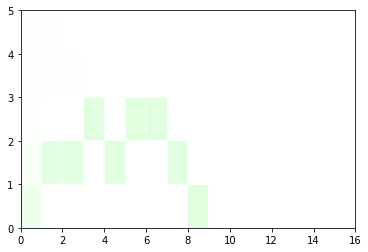

In [27]:
p_TR_correct_TP
alpha = .5
plt.pcolor(p_TR_correct_TP[:,:,i_s], edgecolors='none', linewidths=1, cmap=cmapCorrect, vmin=0.0, vmax=1.0,alpha=alpha)
plt.pcolor(p_TR_error_TP[:,:,i_s], edgecolors='none', linewidths=1, cmap=cmapError, vmin=0.0, vmax=1.0,alpha=alpha)
plt.pcolor(p_TR_omission_TP[:,:,i_s], edgecolors='none', linewidths=1, cmap=cmapOmission, vmin=0.0, vmax=1.0,alpha=alpha)

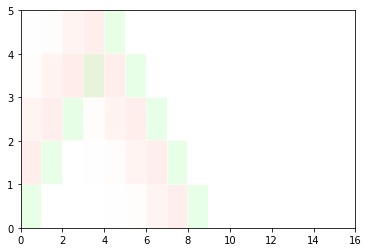

In [28]:
p_TR_correct_TP
alpha = .5
plt.pcolor(p_TR_correct_RP[:,:,i_s], edgecolors='none', linewidths=1, cmap=cmapCorrect, vmin=0.0, vmax=1.0,alpha=alpha)
plt.pcolor(p_TR_error_RP[:,:,i_s], edgecolors='none', linewidths=1, cmap=cmapError, vmin=0.0, vmax=1.0,alpha=alpha)
plt.pcolor(p_TR_omission_RP[:,:,i_s], edgecolors='none', linewidths=1, cmap=cmapOmission, vmin=0.0, vmax=1.0,alpha=alpha)

In [ ]:
plt.close('all')
figsize=(7,7)
fig=plt.figure(figsize=figsize,dpi=600)
gs6= fig.add_gridspec(nrows=1, ncols=3, left=0.55, bottom=0.30, right=0.98, top=0.42,wspace=0.25,hspace=0.3)
axes6=plot_trajectory_distributions(fig, gs6,p_TR_correct_TP,p_TR_error_TP,p_TR_omission_TP,cmapLime,cmapTomato,cmapGray,selected_sessions,alpha=0.5)
axes6[-1].set_yticklabels([])
axes6[-1].set_ylabel('')
for ax in axes6: ax.title.set_fontsize(10)
add_legend_trajectory(axes6[-1])

In [ ]:
print(p_TR_correct_RP[:,:,i_Q])
print(p_TR_correct_TP[:,:,i_Q])

# Some analysis for plots

In [85]:
# This is for the figure of the paper
file_to_open_RP = 'Results_PositionIndexRearWall.pickle'
with open(file_to_open_RP, 'rb') as f:
    [all_times_median_RP, all_times_std_RP,TR_correct_last_RP,TR_error_last_RP,TR_omission_last_RP,sequence_all_states_last_RP,correct_all_last_RP,TR_correct_RP,TR_error_RP,TR_omission_RP,sequence_all_states_RP,correct_all_RP] = pickle.load(f)

file_to_open_TP = 'Results_TimePositionIndex.pickle'
with open(file_to_open_TP, 'rb') as f:
    [all_times_median_TP, all_times_std_TP,TR_correct_last_TP,TR_error_last_TP,TR_omission_last_TP,sequence_all_states_last_TP,correct_all_last_TP,TR_correct_TP,TR_error_TP,TR_omission_TP,sequence_all_states_TP,correct_all_TP] = pickle.load(f)    

###########################################################################################
# This is for the pcolor plot of the trajectories
###########################################################################################    
cmapTomato = LinearSegmentedColormap.from_list('mycmap', ['white', 'Tomato'])
cmapLime = LinearSegmentedColormap.from_list('mycmap', ['white', 'Lime'])
cmapGray = LinearSegmentedColormap.from_list('mycmap', ['white', 'Gray'])


cmapError = cmapTomato
cmapCorrect = cmapLime
cmapOmission = cmapGray


colorTwin1 = 'Olive'

###########################################################################################
goalTime = time_min
###########################################################################################
selected_sessions = [0,9,29]
#selected_sessions = [0,3*int(n_sessions/10),int(5.8*int(n_sessions/10)),n_sessions-1]
###########################################################################################

selected_agents_TP = [1,7,8,10]
###########################################################################################
p_TR_correct = np.zeros(TR_correct.shape)
p_TR_error = np.zeros(TR_error.shape)
p_TR_omission = np.zeros(TR_omission.shape)

p_TR_correct_RP = np.zeros(TR_correct_RP.shape)
p_TR_error_RP = np.zeros(TR_error_RP.shape)
p_TR_omission_RP = np.zeros(TR_omission_RP.shape)

p_TR_correct_TP = np.zeros(TR_correct_TP.shape)
p_TR_error_TP = np.zeros(TR_error_TP.shape)
p_TR_omission_TP = np.zeros(TR_omission_TP.shape)

p_TR_correct_last_TP = np.zeros(TR_correct_last_TP.shape)
p_TR_error_last_TP = np.zeros(TR_error_last_TP.shape)
p_TR_omission_last_TP = np.zeros(TR_omission_last_TP.shape)

# for i_s in range(n_sessions):
#     if np.max(TR_error[:,:,i_s]) >= np.max(TR_correct[:,:,i_s]):
#         TR_norm = np.max(TR_error[:,:,i_s])
#     else:
#         TR_norm = np.max(TR_correct[:,:,i_s])
#     p_TR_correct[:,:,i_s] = TR_correct[:,:,i_s]/TR_norm
#     p_TR_error[:,:,i_s] = TR_error[:,:,i_s]/TR_norm

for i_s in range(n_sessions):
    TR_norm = np.max(TR_error[:,:,i_s]+TR_correct[:,:,i_s]+TR_omission[:,:,i_s])
    p_TR_correct[:,:,i_s] = TR_correct[:,:,i_s]/TR_norm
    p_TR_error[:,:,i_s] = TR_error[:,:,i_s]/TR_norm
    p_TR_omission[:,:,i_s] = TR_omission[:,:,i_s]/TR_norm
    
    TR_norm_RP = np.max(TR_error_RP[:,:,i_s]+TR_correct_RP[:,:,i_s]+TR_omission_RP[:,:,i_s])
    p_TR_correct_RP[:,:,i_s] = TR_correct_RP[:,:,i_s]/TR_norm_RP
    p_TR_error_RP[:,:,i_s] = TR_error_RP[:,:,i_s]/TR_norm_RP
    p_TR_omission_RP[:,:,i_s] = TR_omission_RP[:,:,i_s]/TR_norm_RP
    
    TR_norm_TP = np.max(TR_error_TP[:,:,i_s]+TR_correct_TP[:,:,i_s]+TR_omission_TP[:,:,i_s])
    p_TR_correct_TP[:,:,i_s] = TR_correct_TP[:,:,i_s]/TR_norm_TP
    p_TR_error_TP[:,:,i_s] = TR_error_TP[:,:,i_s]/TR_norm_TP
    p_TR_omission_TP[:,:,i_s] = TR_omission_TP[:,:,i_s]/TR_norm_TP

n_agents=15

for i_a in range(n_agents):
    TR_last_norm_TP = np.max(TR_correct_last_TP[:,:,i_a]+TR_error_last_TP[:,:,i_a]+TR_omission_last_TP[:,:,i_a])
    p_TR_correct_last_TP[:,:,i_a] = TR_correct_last_TP[:,:,i_a]/TR_last_norm_TP
    p_TR_error_last_TP[:,:,i_a] = TR_error_last_TP[:,:,i_a]/TR_last_norm_TP
    p_TR_omission_last_TP[:,:,i_a] = TR_omission_last_TP[:,:,i_a]/TR_last_norm_TP
    
###########################################################################################

# This is for median and SDT 
#################################################################################
med = np.zeros((n_sessions))
highErr = np.zeros((n_sessions))
lowErr = np.zeros((n_sessions))
std_ET = np.zeros((n_sessions))
for i_s in range(len(sessions)-1):
    med[i_s] = np.nanpercentile([x for x in entrance_times[sessions[i_s]:sessions[i_s+1]] if x is not 15],50)
    highErr[i_s] = np.nanpercentile([x for x in entrance_times[sessions[i_s]:sessions[i_s+1]] if x is not 15],75)
    lowErr[i_s] = np.nanpercentile([x for x in entrance_times[sessions[i_s]:sessions[i_s+1]] if x is not 15],25)
    std_ET[i_s] = np.std([x for x in entrance_times[sessions[i_s]:sessions[i_s+1]] if x is not 15])

seed_number = seed_vector[-1]
######################

# Figure paper

In [21]:
file_to_open_RP = 'Results_PositionIndexRearWall.pickle'
with open(file_to_open_RP, 'rb') as f:
    [all_times_median_RP, all_times_std_RP,TR_correct_last_RP,TR_error_last_RP,TR_omission_last_RP,sequence_all_states_last_RP,TR_correct_RP,TR_error_RP,TR_omission_RP,sequence_all_states_RP] = pickle.load(f)

file_to_open_TP = 'Results_TimePositionIndex.pickle'
with open(file_to_open_TP, 'rb') as f:
    [all_times_median_TP, all_times_std_TP,TR_correct_last_TP,TR_error_last_TP,TR_omission_last_TP,sequence_all_states_last_TP,TR_correct_TP,TR_error_TP,TR_omission_TP,sequence_all_states_TP] = pickle.load(f)    

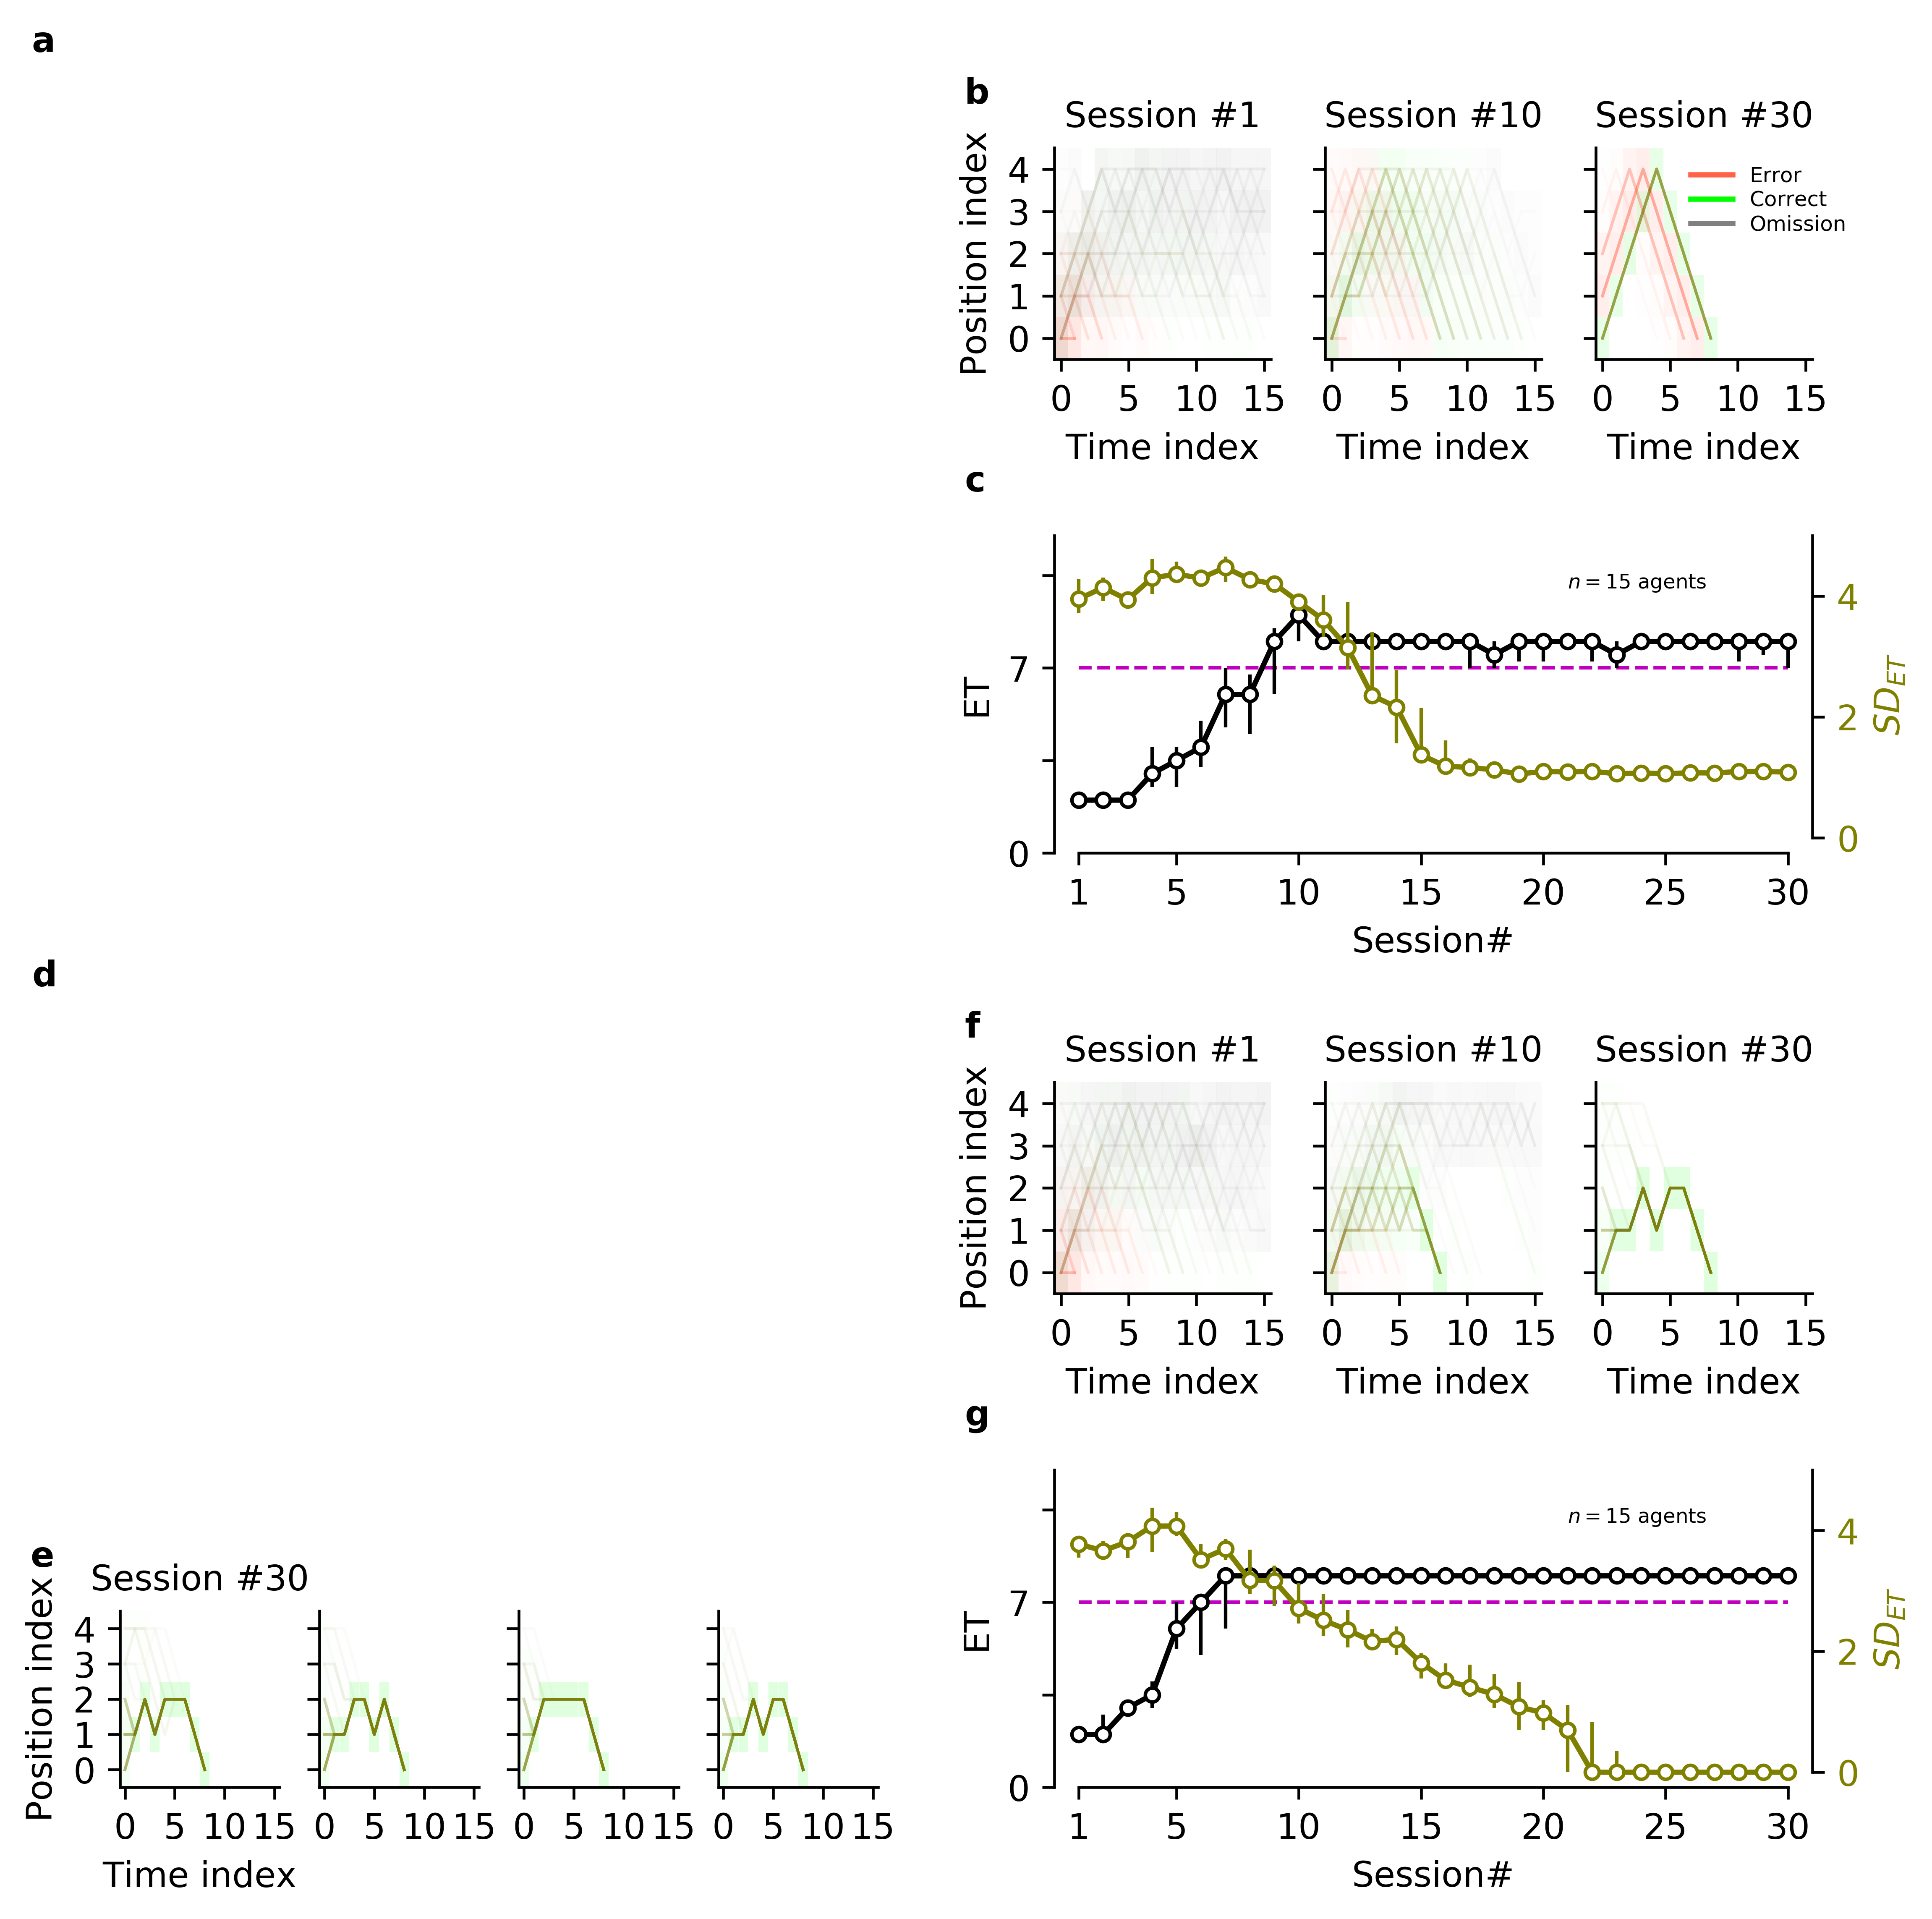

In [89]:
plt.close('all')
figsize=(7,7)
fig=plt.figure(figsize=figsize,dpi=600)

################################################################################
#Panel A: blank space for the schematic of the model position and rear
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.02, bottom=0.55, right=0.45, top=.98)
ax1= fig.add_subplot(gs1[0])
ax1.axis('off')

################################################################################
#Panel B

gs2= fig.add_gridspec(nrows=1, ncols=3, left=0.55, bottom=0.83, right=0.98, top=0.95,wspace=0.25,hspace=0.3)
axes2= plot_trajectory_distributions(fig, gs2,p_TR_correct_RP,p_TR_error_RP,p_TR_omission_RP,sequence_all_states_RP,correct_all_RP,cmapLime,cmapTomato,cmapGray,selected_sessions,alpha=0.5)
axes2[-1].set_yticklabels([])
axes2[-1].set_ylabel('')
for ax in axes2: ax.title.set_fontsize(10)
add_legend_trajectory(axes2[-1])


################################################################################
#Panel C
gs3= fig.add_gridspec(nrows=1, ncols=1, left=0.55, bottom=0.55, right=0.98, top=0.73,wspace=0.3,hspace=0.3)
#axes5= plot_trajectory_distributions(fig, gs5,variables)
ax3=fig.add_subplot(gs3[0])

TaskParamToPlot = "ET"
plot_learning_curve(ax3,all_times_median_RP,goalTime,seed_vector,n_sessions,TaskParamToPlot,color='k')
ax3.set_ylabel(TaskParamToPlot)
ax3.set_xlabel('Session#')

TaskParamToPlot = r'$SD_{ET}$'
colorTwin1 = 'Olive'
TaskTwinLabel1 = TaskParamToPlot
ax3_ = ax3.twinx()
plot_learning_curve(ax3_,all_times_std_RP,goalTime,seed_vector,n_sessions,TaskParamToPlot,color=colorTwin1)
ax3_.set_ylim([-0.25,5])
ax3_.set_yticks([0,2,4])
ax3_.set_yticklabels([0,2,4])
ax3_.xaxis.set_visible(False)
ax3_.spines['bottom'].set_visible(False)
ax3_.spines['top'].set_visible(False)
ax3_.spines['left'].set_visible(False)
ax3_.spines['right'].set_visible(True)
ax3_.spines['right'].set_bounds(0,5)
ax3_.tick_params(axis='y', labelcolor=colorTwin1)
ax3_.set_ylabel(TaskTwinLabel1, color=colorTwin1)

################################################################################
#Panel D
#gs4 = fig.add_gridspec(nrows=1,ncols=1,left=0.02,bottom=0.27,right=0.45,top=0.45)
gs4 = fig.add_gridspec(nrows=1,ncols=1,left=0.02,bottom=0.22,right=0.45,top=0.45)
ax4=fig.add_subplot(gs4[0])
ax4.axis('off')

################################################################################
#Panel E
#gs5= fig.add_gridspec(nrows=1, ncols=3, left=0.02, bottom=0.02, right=0.45, top=0.17,wspace=0.25,hspace=0.3)
gs5= fig.add_gridspec(nrows=1, ncols=4, left=0.02, bottom=0.02, right=0.45, top=0.12,wspace=0.25,hspace=0.3)
axes5=plot_final_trajectory_many_agents(fig, gs5,p_TR_correct_last_TP,p_TR_error_last_TP,p_TR_omission_last_TP,sequence_all_states_last_TP,correct_all_last_TP,cmapCorrect,cmapError,cmapOmission,selected_agents_TP,alpha=0.5)
axes5[-1].set_yticklabels([])
axes5[-1].set_ylabel('')
for ax in axes5: ax.title.set_fontsize(10)
#add_legend_trajectory(axes5[-1])

################################################################################
#Panel F
gs6= fig.add_gridspec(nrows=1, ncols=3, left=0.55, bottom=0.30, right=0.98, top=0.42,wspace=0.25,hspace=0.3)
axes6=plot_trajectory_distributions(fig, gs6,p_TR_correct_TP,p_TR_error_TP,p_TR_omission_TP,sequence_all_states_TP,correct_all_TP,cmapLime,cmapTomato,cmapGray,selected_sessions,alpha=0.5)
axes6[-1].set_yticklabels([])
axes6[-1].set_ylabel('')
for ax in axes6: ax.title.set_fontsize(10)
#add_legend_trajectory(axes6[-1])

################################################################################
#Panel G
gs7 = fig.add_gridspec(nrows=1,ncols=1,left=0.55,bottom=0.02,right=0.98,top=0.20)
ax7=fig.add_subplot(gs7[0])

TaskParamToPlot = "ET"
plot_learning_curve(ax7,all_times_median_TP,goalTime,seed_vector,n_sessions,TaskParamToPlot,color='k')
ax7.set_ylabel(TaskParamToPlot)
ax7.set_xlabel('Session#')

TaskParamToPlot = r'$SD_{ET}$'
colorTwin1 = 'Olive'
TaskTwinLabel1 = TaskParamToPlot
ax7_ = ax7.twinx()
plot_learning_curve(ax7_,all_times_std_TP,goalTime,seed_vector,n_sessions,TaskParamToPlot,color=colorTwin1)
ax7_.set_ylim([-0.25,5])
ax7_.set_yticks([0,2,4])
ax7_.set_yticklabels([0,2,4])
ax7_.xaxis.set_visible(False)
ax7_.spines['bottom'].set_visible(False)
ax7_.spines['top'].set_visible(False)
ax7_.spines['left'].set_visible(False)
ax7_.spines['right'].set_visible(True)
ax7_.spines['right'].set_bounds(0,5)
ax7_.tick_params(axis='y', labelcolor=colorTwin1)
ax7_.set_ylabel(TaskTwinLabel1, color=colorTwin1)


##########################################################################################################    
AXES=([ax1,axes2[0],ax3,ax4,axes5[0],axes6[0],ax7])
OFFX=(.05,)*len(AXES)
OFFY=(.03,)*len(AXES)
add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)     
##########################################################################################################

fig.savefig('Prova.pdf',bbox_inches='tight')


# Final plots

In [ ]:
# THIS IS FOR A 2 COLS FIGURE

plt.close('all')
figsize=(7,7)
fig=plt.figure(figsize=figsize,dpi=600)

################################################################################
#blank space for the schematic of the model
gs0 = fig.add_gridspec(nrows=1, ncols=1, left=0.02, bottom=0.58, right=0.48, top=.98)
ax0= fig.add_subplot(gs0[0])
ax0.axis('off')


################################################################################
# 1L: One seed ET and SD progrression
gs1= fig.add_gridspec(nrows=1, ncols=1, left=0.6, bottom=0.83, right=0.98, top=.98)
ax1= fig.add_subplot(gs1[0])
plot_agent_ET(ax1, med, highErr, lowErr,goalTime,n_sessions,color='k')

ax1_ = ax1.twinx()
plot_agent_SD(ax1_, std_ET, seed_number,n_sessions,color=colorTwin1)    


ax1_.set_ylim([0,5])
ax1_.set_yticks([0,2,4])
ax1_.set_yticklabels([0,2,4])
ax1_.xaxis.set_visible(False)
ax1_.spines['bottom'].set_visible(False)
ax1_.spines['top'].set_visible(False)
ax1_.spines['left'].set_visible(False)
ax1_.spines['right'].set_bounds(0,5)
ax1_.tick_params(axis='y', labelcolor=colorTwin1)
ax1_.set_ylabel(TaskTwinLabel1, color=colorTwin1)
##################################################

# 1R: All seeds (15) ET and SD progrression

gs2= fig.add_gridspec(nrows=1, ncols=1, left=0.6, bottom=0.58, right=0.98, top=.73)
ax2= fig.add_subplot(gs2[0])

TaskParamToPlot = "ET"
plot_learning_curve(ax2,all_times_median,goalTime,seed_vector,n_sessions,TaskParamToPlot,color='k')
ax2.set_ylabel(TaskParamToPlot)
ax2.set_xlabel('Session#')

TaskParamToPlot = r'$SD_{ET}$'
colorTwin1 = 'Olive'
TaskTwinLabel1 = TaskParamToPlot
ax2_ = ax2.twinx()
plot_learning_curve(ax2_,all_times_std,goalTime,seed_vector,n_sessions,TaskParamToPlot,color=colorTwin1)
ax2_.set_ylim([0,5])
ax2_.set_yticks([0,2,4])
ax2_.set_yticklabels([0,2,4])
ax2_.xaxis.set_visible(False)
ax2_.spines['bottom'].set_visible(False)
ax2_.spines['top'].set_visible(False)
ax2_.spines['left'].set_visible(False)
ax2_.spines['right'].set_visible(True)
ax2_.spines['right'].set_bounds(0,5)
ax2_.tick_params(axis='y', labelcolor=colorTwin1)
ax2_.set_ylabel(TaskTwinLabel1, color=colorTwin1)

##########################################################################################################
##########################################################################################################

# 2: Probabilities trajectories

gs2= fig.add_gridspec(nrows=1, ncols=4, left=0.02, bottom=0.3, right=0.98, top=0.45,wspace=0.45,hspace=0.3)
axes2= plot_trajectory_distributions(fig, gs2,p_TR_correct,p_TR_error,p_TR_omission,cmapLime,cmapTomato,cmapGray,selected_sessions,alpha=0.5)
axes2[-1].set_yticklabels([])
axes2[-1].set_ylabel('')
for ax in axes2: ax.title.set_fontsize(10)
add_legend_trajectory(axes2[-1])

##########################################################################################################
##########################################################################################################
    
# 3:Entrance times

gs3= fig.add_gridspec(nrows=1, ncols=4, left=0.02, bottom=0.02, right=0.98, top=0.17,wspace=0.45,hspace=0.3)
axes3=plot_entrance_times(fig, gs3,sessions,selected_sessions,correct_all,entrance_times,goalTime)

axes3[-1].set_yticklabels([])
axes3[-1].set_ylabel('')
for ax in axes3: ax.title.set_fontsize(10)    
add_legend_entrance_times(axes3[-1])

    
##########################################################################################################    
AXES=([ax0,ax1,axes2[0],axes3[0]])
OFFX=(.05,)*len(AXES)
OFFY=(.03,)*len(AXES)
add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)     
##########################################################################################################
fig.savefig(results_folder + '/ALL-AGENTS-modelResults_2Cols-and-Agent-betaStep-' + str(invTstep) + '-invT0-' + str(invT_vect[ind_agent]) + '-alpha-' + str(lr) + '-seedN-' + str(seed_num)  + '.pdf',bbox_inches='tight')
   